In [1]:
# Define critical control variables

# Min/max values used to scale the height, lon, and lat
scale_minimum = 0
scale_maximum = 1

In [2]:
# Make the libraries directory searchable for Python imports
import sys
sys.path.insert(1, './libraries')

In [3]:
# Common imports
import os
from pathlib import Path

import numpy as np
import pandas as pd

from datetime import datetime

In [4]:
# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# KMeans import
from sklearn.cluster import KMeans

In [6]:
# Import functions from the utilities file
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [7]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [8]:
chords.select_data_file()

Available Data Files


Output()

In [9]:
# Read contents of the selected file in to a pandas object
file_name = chords.available_data_files.value
print("Imported csv data from " + file_name)

unmodified_data = chords.load_data_from_file(file_name)

unmodified_data["Seconds Since Epoch"] = unmodified_data['Time'].astype(np.int64)

Imported csv data from tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [10]:
# Fill in missing points in the time series
resampled_data = unmodified_data.copy()

resampled_data = resampled_data.set_index('Time').sort_index().resample('1000ms').ffill()

# Re-insert the 'Time' field, as the resampling process set it to be the index
resampled_data['Time'] = resampled_data.index

In [11]:
# Rescale Height, Longitude and Latitude to the range between scale_minimum and scale_maximum
scaled_data = pd.DataFrame()

# Convert the Time variable to Seconds Since Epoch
scaled_data["Seconds Since Epoch"] = resampled_data['Time'].astype(np.int64)
# scaled_data["Time"] = resampled_data['Time']

scaled_data["Scaled Height"] = scale_np_data(resampled_data["Height"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Latitude"] = scale_np_data(resampled_data["Latitude"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Longitude"] = scale_np_data(resampled_data["Longitude"].to_numpy(), scale_minimum, scale_maximum)

In [12]:
# Treat the individual fields as dimensions of a vector and calculate the vector magnitude value as a derived feature
fields_list = ['Scaled Height', 'Scaled Latitude', 'Scaled Longitude']

scaled_data["Vector Magnitude"] = calculate_vector_magnitude(scaled_data, fields_list, scale_minimum, scale_maximum)

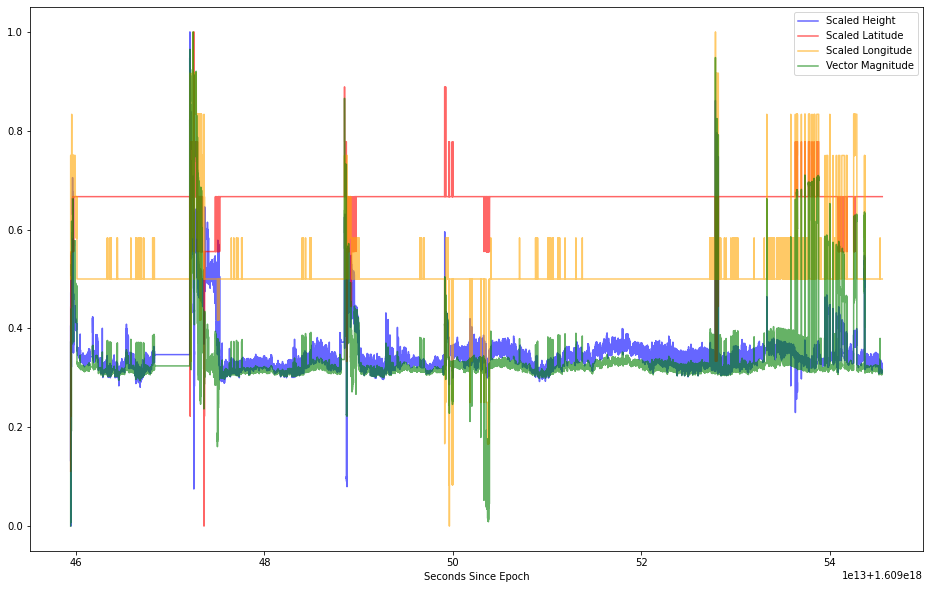

In [13]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Vector Magnitude', color='green', ax=ax, alpha=alpha)

plt.show()

In [14]:
scaled_data.keys()

Index(['Seconds Since Epoch', 'Scaled Height', 'Scaled Latitude',
       'Scaled Longitude', 'Vector Magnitude'],
      dtype='object')

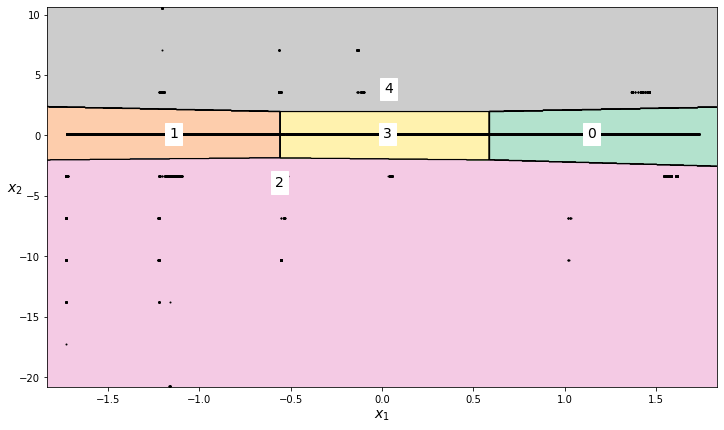

In [27]:
# Generate a Kmeans cluster 
field_to_analyze = 'Scaled Latitude'
number_of_clusters = 5

# Impute and scale the data 
scaled_latitude_imputed_data = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
scaled_latitude_kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)

scaled_latitude_cluster_labels = scaled_latitude_kmeans.fit_predict(scaled_latitude_imputed_data)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(scaled_latitude_kmeans, scaled_latitude_imputed_data)

In [28]:
# Based on the labeled regions from the decision boundary plot, decide which regions should be retained
scaled_latitude_regions_to_retain = [1,3,0]

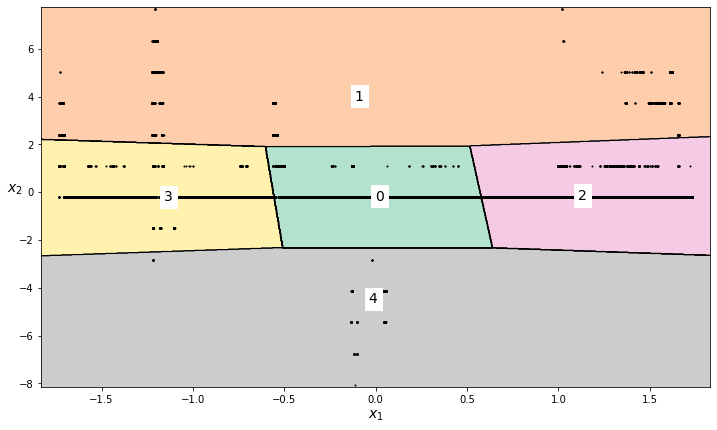

In [29]:
field_to_analyze = 'Scaled Longitude'
number_of_clusters = 5


# Impute the data 
scaled_longitude_data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
scaled_longitude_kmeans = KMeans(n_clusters=number_of_clusters, random_state=41)

scaled_longitude_cluster_labels = scaled_longitude_kmeans.fit_predict(scaled_longitude_data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(scaled_longitude_kmeans, scaled_longitude_data_imputed)

In [30]:
# Based on the labeled regions from the decision boundary plot, decide which regions should be retained
scaled_longitude_regions_to_retain = [3,0,2]

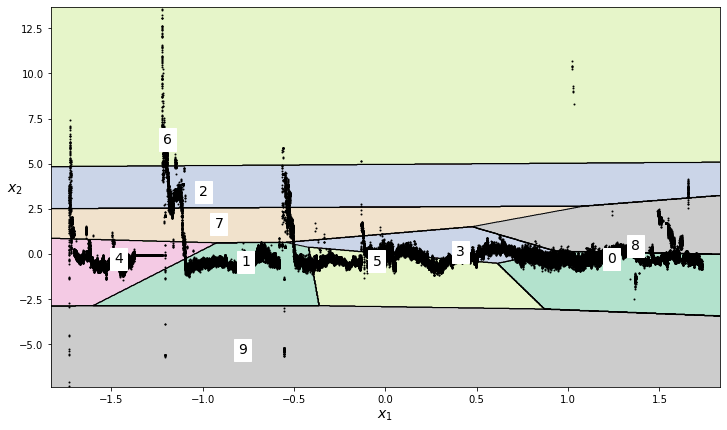

In [31]:
field_to_analyze = 'Scaled Height'
number_of_clusters = 10

# Impute the data 
scaled_height_data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
scaled_height_kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)

scaled_height_cluster_labels = scaled_height_kmeans.fit_predict(scaled_height_data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(scaled_height_kmeans, scaled_height_data_imputed)

In [32]:
# Based on the labeled regions from the decision boundary plot, decide which regions should be retained
scaled_height_regions_to_retain = [4,1,5,3,0,8]

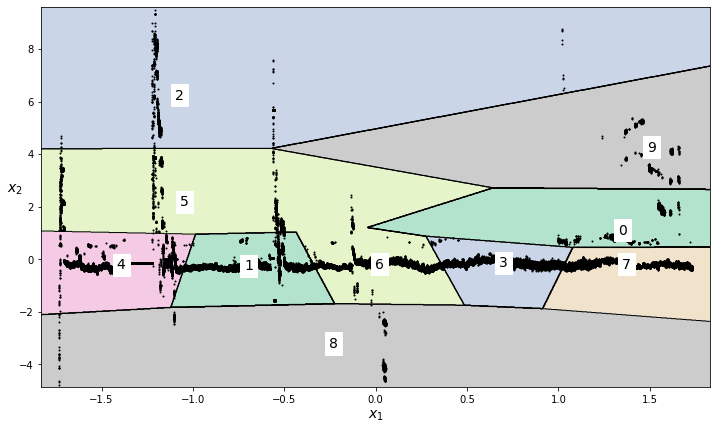

In [33]:
field_to_analyze = 'Vector Magnitude'
number_of_clusters = 10

# Impute the data 
vector_magnitude_data_imputed = transform_data_for_kmeans(scaled_data, field_to_analyze)

# Train the Kmeans model
vector_magnitude_kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)

vector_magnitude_cluster_labels = vector_magnitude_kmeans.fit_predict(vector_magnitude_data_imputed)

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(vector_magnitude_kmeans, vector_magnitude_data_imputed)

In [34]:
# Based on the labeled regions from the decision boundary plot, decide which regions should be retained
vector_magnitude_regions_to_retain = [4,1,6,3,7]

In [44]:
# Selectively remove data points from the list

# Create a new containerd for the cleaned data
cleaned_data = pd.DataFrame()

# Convert the Time variable to Seconds Since Epoch
cleaned_data["Seconds Since Epoch"] = resampled_data['Time'].astype(np.int64)


cleaned_data["Height"] = resampled_data["Height"]
cleaned_data["Longitude"] = resampled_data["Longitude"]
cleaned_data["Latitude"] = resampled_data["Latitude"]
cleaned_data["Vector Magnitude"] = vector_magnitude_data_imputed[:,-1]


# Create a new column in the panadas object for the cluster labels for each dimension
cleaned_data['scaled_height_kmeans'] = scaled_height_cluster_labels
cleaned_data['scaled_longitude_kmeans'] = scaled_longitude_cluster_labels
cleaned_data['scaled_latitude_kmeans'] = scaled_latitude_cluster_labels
cleaned_data['vector_magnitude_kmeans'] = vector_magnitude_cluster_labels


# For each dimension, keep only the designated rows
cleaned_data = cleaned_data[cleaned_data.scaled_height_kmeans.isin(scaled_height_regions_to_retain)]
cleaned_data = cleaned_data[cleaned_data.scaled_longitude_kmeans.isin(scaled_longitude_regions_to_retain)]
cleaned_data = cleaned_data[cleaned_data.scaled_latitude_kmeans.isin(scaled_latitude_regions_to_retain)]
cleaned_data = cleaned_data[cleaned_data.vector_magnitude_kmeans.isin(vector_magnitude_regions_to_retain)]

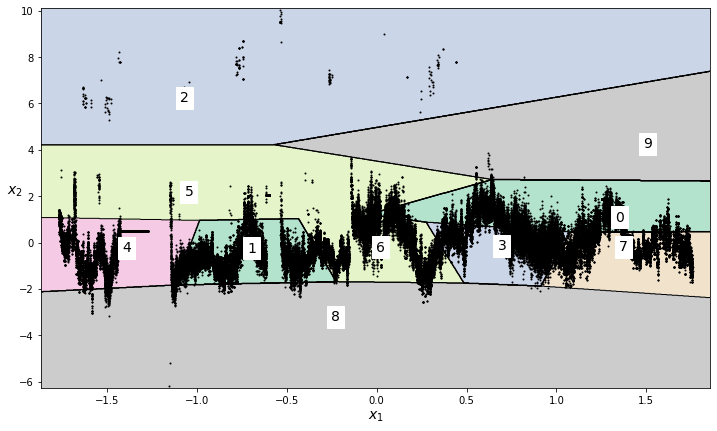

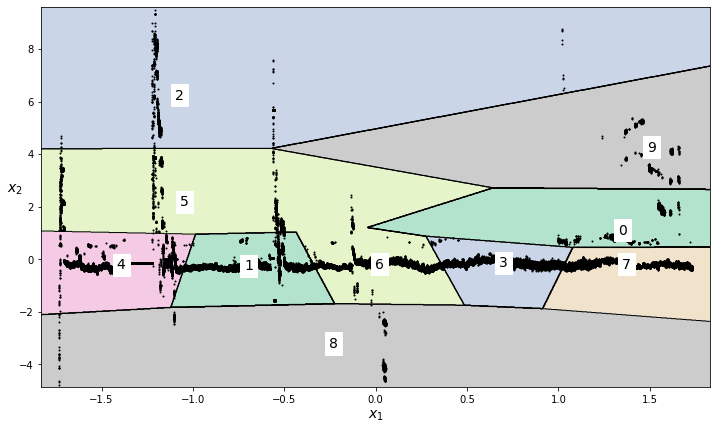

In [45]:
# field_to_analyze = 'Height'
field_to_analyze = 'Vector Magnitude'

# Impute the data 
vector_magnitude_cleaned_data_imputed = transform_data_for_kmeans(cleaned_data, field_to_analyze)

# print(cleaned_data_imputed[:,-1].size)


# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(vector_magnitude_kmeans, vector_magnitude_cleaned_data_imputed)
plt.show()

# Plot the decision boundaries
plt.figure(figsize=(12, 7))
plot_decision_boundaries(vector_magnitude_kmeans, vector_magnitude_data_imputed)
plt.show()
